# Flood Duration

In this notebook we'll continue to look at the statistics of flood duration and explore different ways to visualize it.

## Setup and Prep Data
We'll begin by running the setup notebook and then bringing in our SL_daily_max file that we made in the [Annual Flood Frequency](../Annual/2_1_FloodFrequency.ipynb) notebook.

In [2]:
%run ../0_1_setup.ipynb


# load the data
SL_daily_max = xr.open_dataset(data_dir / 'SL_daily_max.nc',decode_timedelta=False)

# We'll pick a period of record for our stats
SL_daily_max = SL_daily_max.sel(time=slice('1993-01-01', '2024-12-31'))


rsl = xr.open_dataset(data_dir / 'rsl_hawaii_noaa.nc',decode_timedelta=False)
rsl_subset = rsl.sel(time=slice('1993-01-01', '2024-12-31'))
# get min and max for each month by resampling
rsl_daily_min = rsl_subset.resample(time='1D').min()
rsl_daily_max = rsl_subset.resample(time='1D').max()

# Filter out leap days (Feb 29) before calculating climatology
rsl_daily_max_no_leap = rsl_daily_max.sel(time=~((rsl_daily_max.time.dt.month == 2) & (rsl_daily_max.time.dt.day == 29)))
rsl_daily_min_no_leap = rsl_daily_min.sel(time=~((rsl_daily_min.time.dt.month == 2) & (rsl_daily_min.time.dt.day == 29)))

rsl_climo_max = rsl_daily_max_no_leap.groupby('time.dayofyear').mean('time')
rsl_climo_min = rsl_daily_min_no_leap.groupby('time.dayofyear').mean('time')

Using custom paths from config_env.py
Data directory: /Users/jfiedler/Projects/SL_Indicators/data
Output directory: /Users/jfiedler/Projects/SL_Indicators/output


In [3]:
rsl_subset

<xarray.Dataset> Size: 18MB
Dimensions:          (station_id: 7, time: 280489)
Coordinates:
  * time             (time) datetime64[ns] 2MB 1993-01-01 ... 2024-12-31
  * station_id       (station_id) <U7 196B '1617760' '1619910' ... '1611400'
Data variables:
    sea_level        (station_id, time) float64 16MB ...
    station_name     (station_id) <U27 756B 'Hilo, Hilo Bay, Kuhio Bay' ... '...
    station_country  (station_id) <U3 84B 'USA' 'USA' 'USA' ... 'USA' 'USA'
    lat              (station_id) float64 56B 19.73 28.21 20.04 ... 21.3 21.95
    lon              (station_id) float64 56B 204.9 182.6 204.2 ... 202.1 200.6
    MHHW             (station_id) float64 56B 1.927 1.206 1.444 ... 1.741 1.255
    MSL              (station_id) float64 56B 1.545 1.02 1.08 ... 1.412 0.949
    MLLW             (station_id) float64 56B 1.196 0.824 0.802 ... 1.161 0.697

In [4]:
def circular_rolling_mean(da, window, dim="dayofyear"):
    if window % 2 == 0:
        raise ValueError("Use an odd window (e.g., 7, 15, 31) for centered rolling.")
    half = window // 2
    da_pad = da.pad({dim: (half, half)}, mode="wrap")
    rolled = da_pad.rolling({dim: window}, center=True, min_periods=window).mean()
    return rolled.isel({dim: slice(half, -half)}).assign_coords({dim: da[dim]})

rsl_climo_max_smooth = circular_rolling_mean(rsl_climo_max, window=45, dim="dayofyear")
rsl_climo_min_smooth = circular_rolling_mean(rsl_climo_min, window=45, dim="dayofyear")

Then we'll make a dictionary to hold all flood events. As before, the flood days here will be defined by the threshold used previously. (Forgot what we used? It should be saved in the netcdf file.) It will be set up such that for each year, there is a list of flood events with their respective length (in days). For example: {'year': 2004, 'events': [2, 1, 5, 3, 5, 1, 4, 1, 1, 4, 1, 4]}

## Make a plot of duration (in days) through time of year

In [5]:
# Extracting the necessary data
flood_day = SL_daily_max['flood_day']
time = SL_daily_max['time']
station_names = SL_daily_max['station_name'].values
station_dict = {name: SL_daily_max['station_id'].values[i] for i, name in enumerate(station_names)}

# Convert time to pandas datetime
time = pd.to_datetime(time.values)

# Initialize a dictionary to hold results
flood_events = {}

# Loop through each station
for i, station in enumerate(station_names):
    station_flood_days = flood_day[:, i].values
    station_flood_days = pd.Series(station_flood_days, index=time)
    
    # Group by year
    station_flood_days_by_month = station_flood_days.groupby(station_flood_days.index.month)
    
    # Initialize list to hold all events for this station
    station_events = []
    
    for month, data in station_flood_days_by_month:
        flood_event_durations = []
        current_event_length = 0
        
        for day in data:
            if day:
                current_event_length += 1
            else:
                if current_event_length > 0:
                    flood_event_durations.append(current_event_length)
                current_event_length = 0
        
        # Append the last event if it was ongoing at the end of the year
        if current_event_length > 0:
            flood_event_durations.append(current_event_length)
        
        # Store the events for this year
        station_events.append({
            "month": month,
            "events": flood_event_durations
        })
    
    # Store the results for the station
    flood_events[station] = station_events

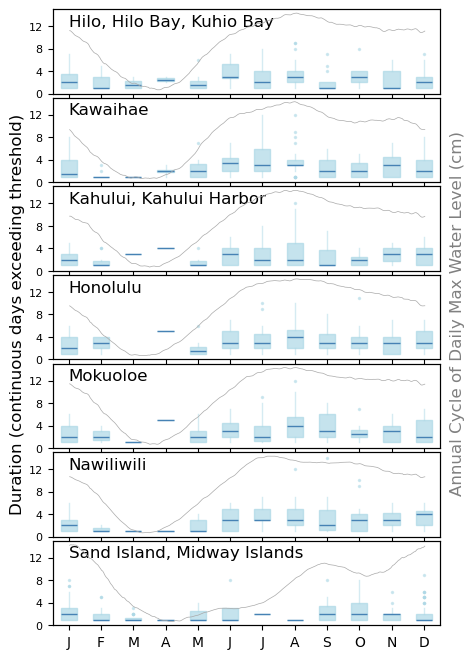

In [6]:
# Configure the plot grid with larger station names

# Extract unique months from the dataset, sorted for plotting
# months = sorted({month_data["month"] for station_events in flood_events.values() for month_data in station_events})
months = list(range(1,13))  # ensure all months are represented
# Define the number of stations and 5-year interval ticks
num_stations = len(station_names)
# five_year_ticks = [year for year in years if year % 5 == 0]

# Create subplots: one per station, sharing the x-axis
fig, axes = plt.subplots(nrows=num_stations, ncols=1, figsize=(5, 8), sharex=True)
plt.subplots_adjust(hspace=0.05)  # Decrease hspace value to bring subplots closer

# Generate boxplots for each station
for ax, station in zip(axes, station_names):
    monthly_durations = {month: [] for month in months}

    # Gather flood event durations per year for the current station
    for month_data in flood_events[station]:
        monthly_durations[month_data["month"]].extend(month_data["events"])

    # Prepare the boxplot data
    boxplot_data = [monthly_durations[month] for month in months]

    # Create the boxplot with customized aesthetics
    ax.boxplot(
        boxplot_data,
        positions=range(len(months)),
        patch_artist=True,
        boxprops=dict(facecolor='lightblue', color='lightblue', alpha=0.7),
        medianprops=dict(color='steelblue'),
        whiskerprops=dict(color='lightblue', alpha=0.5),
        capprops=dict(color=None, alpha=0),
        flierprops=dict(marker='.', markerfacecolor='lightblue', markeredgecolor='lightblue', alpha=0.5, markersize=3)
    )
    ax.set_ylim(0, 15)
    

    # make axis on right side
    ax2 = ax.twinx()
    hi_sl = rsl_climo_max_smooth['sea_level'].sel(station_id=station_dict[station])-rsl_subset['MHHW'].sel(station_id=station_dict[station])
    hi_sl_month = hi_sl['dayofyear']/365*11  # convert dayofyear to month
    ax2.plot(hi_sl_month, 100*hi_sl, color='darkgray', linewidth=0.5)
    # Set yticklabels with correct argument
    ax2.set_yticks([])
    ax2.set_yticklabels([])

    # Label each subplot with the station name
    ax.text(0, ax.get_ylim()[1] * 0.8, station, fontsize=12, ha='left', color='black')
    ax.set_yticks(range(0, 16, 4))
    ax.set_yticklabels(range(0, 16, 4),fontsize=8)

# Remove x-axis labels from all but the last subplot
for ax in axes[:-1]:
    ax.set_xticks([])

# add month abbreviations to x-axis
axes[-1].set_xticks(np.arange(0,12,1))
axes[-1].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])

# Add a single y-axis label for the entire figure
fig.text(0.04, 0.5, 'Duration (continuous days exceeding threshold)', va='center', rotation='vertical', fontsize=12)
fig.text(0.92, 0.5, 'Annual Cycle of Daily Max Water Level (cm)', va='center', rotation='vertical', fontsize=12, color='gray')


# glue the figure
glue("tseries", fig, display=False)

```{glue:figure} tseries
:name: "flood duration timeseries"

Time series of continuous days exceeding a given threshold all the Hawaiian Island stations, shown as a box plot throughout the year. The median number of days for each event are shown in darker blue lines. Outliers are denoted as small dots. The annual cycle of daily max water level (smoothed) is shown in the gray line, nicely illustrating the seasonal distribution of flood events (aka plan all your low lying camping events for March and April. Statistically speaking, you probably won't have to move your tent. Unless it rains of course.)
```

## Plot frequency and duration (in days) in a circle
If you're feeling adventurous, you can view time as a flat circle.

In [7]:
months = list(range(1, 13))

def month_duration_stats(flood_events, station):
    """
    flood_events[station]: list of dicts like
      {"year": 2017, "month": m, "events": [dur1, dur2, ...]}   # durations in days (or hours)
    Returns arrays length-12: avg duration, count of events.
    """
    by_month = {m: [] for m in months}
    for rec in flood_events[station]:
        m = rec["month"]
        by_month[m].extend(rec.get("events", []))

    avg_durs = np.array([np.mean(by_month[m]) if by_month[m] else 0.0 for m in months], float)
    counts   = np.array([len(by_month[m])                    for m in months], int)
    return avg_durs, counts

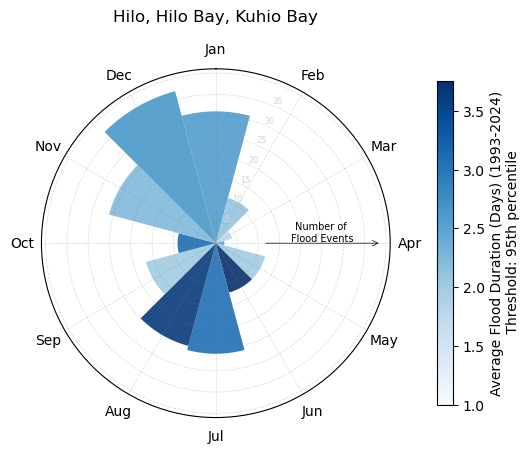

In [8]:
import calendar
import matplotlib.cm as cm

def plot_station_spokes_color(flood_events, station):
    avg_durs, counts = month_duration_stats(flood_events, station)
    theta = np.linspace(0, 2*np.pi, 12, endpoint=False)
    counts = np.array(counts)  # ensure counts is a numpy array
    avg_durs = np.array(avg_durs)
    # normalize counts for colormap
    norm = plt.Normalize(vmin=1, vmax=avg_durs.max())
    cmap = cm.Blues
    
    fig, ax = plt.subplots(subplot_kw={'polar': True}, figsize=(6,6))
    ax.set_theta_offset(np.pi/2)
    ax.set_theta_direction(-1)


    bars = ax.bar(theta, counts, width=2*np.pi/12, align='center',
                  color=cmap(norm(avg_durs)), edgecolor=None, alpha=0.9)




    # change the ticks and labels
    ax.set_ylim(0, max(1, np.ceil(counts.max()*1.1)))
    ax.set_xticks(theta)
    ax.set_xticklabels([m for m in calendar.month_abbr if m])
    # ax.set_yticklabels([])
    # make yticklabels small and gray
    # Set all yticklabels except the last one to small and gray, last one invisible
    yticks = ax.get_yticks()
    yticks = yticks[:-1]
    yticklabels = [str(int(y)) for y in yticks]
    # Set last label to empty string
    if len(yticklabels) > 0:
        yticklabels[-1] = ''
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels, color='lightgray', fontsize=6)
    #remove outer yticklabel

    ax.set_title(station, pad=15)

    # add an arrow on april to label "Counts" axis
    r1, r2 = counts.max()*0.3, ax.get_ylim()[1]*0.95
    # ax.plot([theta[3], theta[3]], [r1, r2], color='k', lw=0.7, zorder=3)
    ax.annotate(
    "",                                # no text
    xy=(theta[3], r2),             # arrow tip
    xytext=(theta[3], r1),         # tail
    arrowprops=dict(arrowstyle="->", color="k", lw=0.5)
    )
    ax.text(theta[3], (0.5*(r1+r2)), "Number of \nFlood Events", ha="center", va="bottom",
        fontsize=7, clip_on=False)


    # add colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.1, shrink=0.7)
    cbar.set_label("Average Flood Duration (Days) (1993-2024)\n Threshold: 95th percentile")

    # make grid lines fainter
    ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

    plt.show()

    return fig, ax

# usage
fig, ax = plot_station_spokes_color(flood_events, station_names[0] )

# glue the figure
glue("circletime", fig, display=False)



```{glue:figure} circletime
:name: "flood duration and frequency in the round"

Here, we are using the same information, but presenting it such that the calendar is a circle instead of a line. The farther out a wedge goes from the circle, the more flood events have been observed that month. For example, August has seen 30 flood events from 1993-2024, using the 95th percentile flooding threshold. Of those 30 events, the average flood duration exceeds 3.5 days (dark blue on the colorbar). Similarly, December and January have many historical events, but they are not as long-lasting as July and August. These months align nicely with "king tide" events, which peak in July/August and December. 
```

## Plot flood duration (in hours) through time

In [9]:
# load hourly data
hourly_data = xr.open_dataset(data_dir / 'SL_hourly_data.nc')

In [10]:
def get_flood_ds(hourly_data = hourly_data, threshold=30):
    flood_hour = (hourly_data.sea_level_MHHW.values > threshold)
    flood_hour
    flood_hour = np.transpose(flood_hour)
    flood_hour_df = pd.DataFrame(flood_hour, index = hourly_data.time.values, columns = hourly_data.station_id.values)

    # get sea level data where flood_hour is True

    flood_data = hourly_data.sea_level_MHHW.where(flood_hour.T)
    flood_data_df = pd.DataFrame(flood_data.T-threshold, index = hourly_data.time.values, columns = hourly_data.station_id.values)

    # Find indices of flood events, and the duration of each event
    # Initialize a dictionary to store the durations
    flood_durations = {}
    flood_heights = {}


    df_flood = flood_hour_df 

    # Loop through each sensor column
    for column in flood_hour_df.columns:
        flood_durations[column] = []
        flood_heights[column] = []

        # Find the indices where flooding starts and ends
        flood_events = df_flood[column].ne(df_flood[column].shift()).cumsum()

        # Group by the flood event indices, filtering out False events
        for event_id, group in df_flood.groupby(flood_events):
            if group[column].iloc[0]:  # Only consider True (flood) events
                start_time = group.index.min()
                end_time = group.index.max()
                duration = end_time - start_time 
                # round to nearest hour
                duration = np.round(duration.total_seconds() / 3600) + 1
                flood_durations[column].append((start_time, duration))
                height = flood_data_df.loc[start_time:end_time, column].max() # max height
                flood_heights[column].append((start_time, height))

    # make dataframe from dictionary
    # Assuming flood_durations and hourly_data are already defined

    # Initialize an empty list to store DataArrays
    data_arrays = []

    # Loop through each station_id and create a DataArray
    for station_id in hourly_data.station_id.values:
        if not flood_durations[station_id]:
            continue  # Skip if there are no flood events
        flood_durations_df = pd.DataFrame(flood_durations[station_id])
        flood_durations_df.columns = ['time', 'duration']

        flood_heights_df = pd.DataFrame(flood_heights[station_id])   
        flood_heights_df.columns = ['time', 'height']

        # Merge the two DataFrames on 'time'
        merged_df = pd.merge(flood_durations_df, flood_heights_df, on='time')

        # Create a DataArray with both 'duration' and 'height'
        flood_data_da = xr.DataArray(
            merged_df[['duration', 'height']].values,
            dims=['time', 'variable'],
            coords={'time': merged_df.time.values, 'variable': ['duration', 'height'], 'station_id': station_id}
        )

        data_arrays.append(flood_data_da)


    # Combine all DataArrays into a single Dataset
    flood_data_ds = xr.concat(data_arrays, dim='station_id',join='outer')

    # Convert to Dataset
    flood_data_ds = flood_data_ds.to_dataset(dim='variable')

    # make storm time by shifting time by 4 months, such that May 1st is the start of the storm season
    # Convert the time values to pandas DatetimeIndex
    time_values = pd.to_datetime(flood_data_ds.time.values)
    
    # Jan 1 should be the equivalent of May 1
    shifted_time_values = time_values + pd.DateOffset(months=4)
    
    #remove anything in 1982
    shifted_time_values = shifted_time_values[shifted_time_values.year != 1982]
    
    
    # Assign the shifted time values back to the dataset
    flood_data_ds['time'] = shifted_time_values

    return flood_data_ds

In [11]:
flood_data_ds = get_flood_ds(hourly_data = hourly_data, threshold=30)

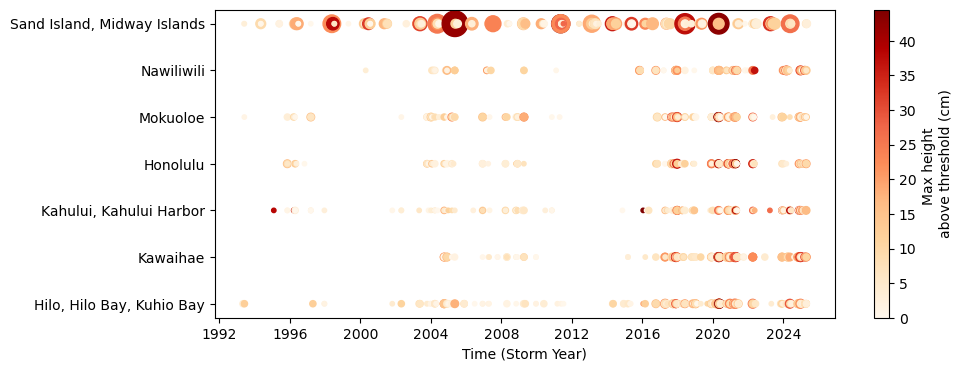

In [12]:
# scatterplot flood duration vs year
from matplotlib.colors import LinearSegmentedColormap

# make figure size small
fig = plt.figure(figsize=(10,4))

# Create a custom color ramp and exclude the lightest shade
full_palette = sns.color_palette("Blues", n_colors=256)
# adjusted_heatmap_palette = full_palette[50:]  # Skip the lightest 50 shades

# Convert the adjusted palette to a colormap
# custom_palette = LinearSegmentedColormap.from_list("custom_blues", adjusted_heatmap_palette)
custom_palette = sns.color_palette("OrRd", as_cmap=True)


# selected_data['duration'] = selected_data['duration'].astype(float)
# flood_durations_ds['month'] = flood_durations_ds['month'].astype(float)

station_ids = flood_data_ds['station_id'].values
station_names = hourly_data['station_name'].sel(station_id=station_ids).values

for i, station_id in enumerate(station_ids):
    # Select data for the current station_id and drop NaNs
    selected_data = flood_data_ds.sel(station_id=station_id).dropna(dim='time')
    
    # Ensure 'duration' is numeric
    selected_data['duration'] = selected_data['duration'].astype(float)
    
    # Plot each station's data on a different y-coordinate
    scatter = plt.scatter(selected_data['time'], [i + 1] * len(selected_data['time']), s=10 * selected_data['duration'], c=selected_data['height'], cmap=custom_palette)

plt.xlabel('Time (Storm Year)')
plt.yticks(range(1, len(station_ids) + 1), hourly_data['station_name'].sel(station_id=station_ids).values)  # Set y-ticks to show station labels
plt.colorbar(scatter, label='Max height \nabove threshold (cm)')


glue("flood_scatter", fig, display=False)

# save figure
fig.savefig(output_dir / 'flood_duration_intra_annual_scatterplot.png', dpi=300, bbox_inches='tight')

# show the colorbar

```{glue:figure} flood_scatter
:name: "flood duration timeseries on a line"

Historical flood events at Hawaiian Island stations. In this plot, duration (in hours) is represented by the size of the circle, with the height above the treshold denoted by the colorbar. Sporadically high events (e.g. Iniki in 1992 at the Nawiliwili and Honolulu gauges) are more obvious when plotted this way. Evidence of regional patterns, such as the wave-like pattern in time for the Hawaii gauges showing a rise in 2005, dip in 2013, and peak again in 2020, are aligned with the astronomical modulation (18.6 and 4.4 yr cycles) of the tides. At Midway this is not so much seen in the number of events but the duration and intensity of those events (size and color of the circles).
```

The rest of this notebook is more experimental. Enjoy.

In [13]:
# scatter plot height vs duration for each station
# make figure size small
from scipy.stats import gaussian_kde

def plot_flood_duration_vs_height(flood_data_ds, station_names, threshold):
    flood_data_ds = get_flood_ds(hourly_data=hourly_data,threshold=threshold)
    # Create figure and subplots
    fig, axes = plt.subplots(2, 4, figsize=(10, 4), sharex=True, sharey=True)  # 2 rows, 4 columns

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Loop through each station
    for i, station_id in enumerate(station_ids):
        # Select data for the current station_id and drop NaNs
        selected_data = flood_data_ds.sel(station_id=station_id).dropna(dim='time')

        # Ensure 'duration' is numeric
        selected_data['duration'] = selected_data['duration'].astype(float)

        # Extract year and apply jitter to duration for better visualization
        jitter_duration = selected_data['duration'] + np.random.uniform(-0.1, 0.1, size=selected_data['duration'].size)

        # Calculate point density
        xy = np.vstack([jitter_duration, selected_data['height']])
        z = gaussian_kde(xy)(xy)

        # Plot each station's data on its respective subplot, using the density (z) as color
        scatter = axes[i].scatter(jitter_duration, selected_data['height'], c=z, cmap='plasma', s=20)

        # # Set labels for each subplot
        axes[i].set_title(station_names[i], fontsize=8)
        # axes[i].set_xlabel('Duration (hours)')
        # axes[i].set_ylabel('Max height above threshold (cm)')

        # set x and y limits
        axes[i].set_xlim(0, 10)
        axes[i].set_ylim(0, 30)

    # Add a common colorbar
    cbar = fig.colorbar(scatter, ax=axes, orientation='vertical', label='Density')

    # Set custom ticks and labels for the colorbar
    cbar.set_ticks([np.min(z), np.mean(z), np.max(z)])
    cbar.set_ticklabels(['Sparse', 'Moderate', 'Dense'], rotation=90,verticalalignment='center',fontsize=8)  # Custom labels

    # add x and y labels
    fig.text(0.45, -0.01, 'Duration (hours)', ha='center', fontsize=12)
    fig.text(0.05, 0.5, 'Max height above threshold (cm) \n (Threshold: {} cm)'.format(threshold), va='center', rotation='vertical', fontsize=12)


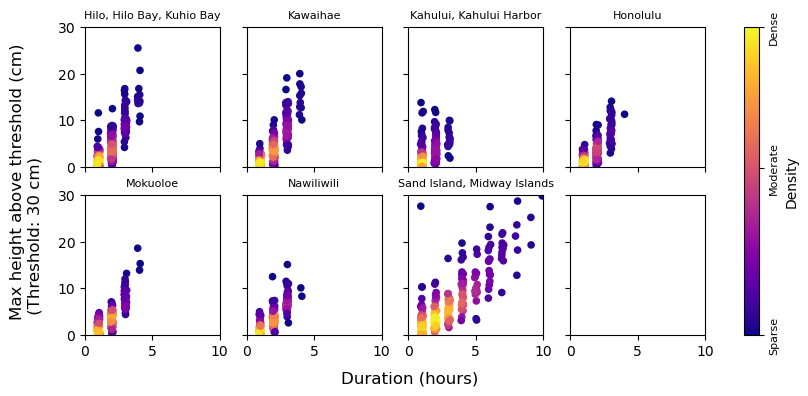

In [14]:
plot_flood_duration_vs_height(flood_data_ds, station_names, 30)

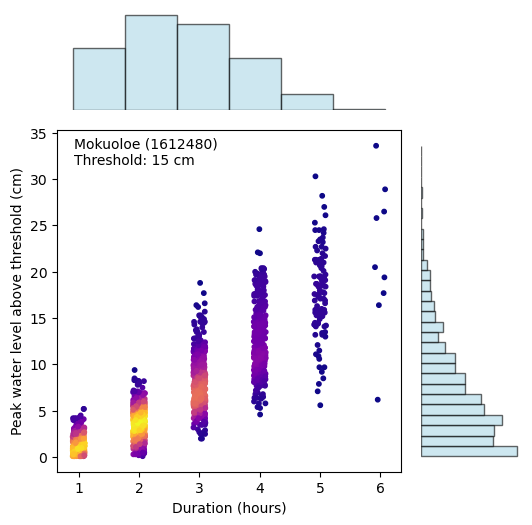

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.gridspec import GridSpec

flood_data_15 = get_flood_ds(hourly_data=hourly_data, threshold=15)

# Example data for one station (you can adjust this to loop through your stations)
station_id = station_ids[4]
station_name = station_names[4]
selected_data = flood_data_15.sel(station_id=station_id).dropna(dim='time')
selected_data['duration'] = selected_data['duration'].astype(float)
jitter_duration = selected_data['duration'] + np.random.uniform(-0.1, 0.1, size=selected_data['duration'].size)

# Calculate point density for color mapping
xy = np.vstack([jitter_duration, selected_data['height']])
z = gaussian_kde(xy)(xy)

# Create the figure and GridSpec layout
fig = plt.figure(figsize=(6, 6))
gs = GridSpec(4, 4, figure=fig)

# Create scatter plot in the center
ax_main = fig.add_subplot(gs[1:4, 0:3])
scatter = ax_main.scatter(jitter_duration, selected_data['height'], c=z, cmap='plasma', s=10)
ax_main.set_xlabel('Duration (hours)')
ax_main.set_ylabel('Peak water level above threshold (cm)')

# add station name to ax_main
station_str = station_name + ' ({})'.format(station_id) + '\nThreshold: 15 cm'
ax_main.text(0.05, 0.9, station_str, fontsize=10, transform=ax_main.transAxes)
# Add colorbar to scatter plot
# cbar = fig.colorbar(scatter, ax=ax_main, orientation='vertical', label='Density')
# cbar.set_ticks([np.min(z), np.mean(z), np.max(z)])
# cbar.ax.set_yticklabels(['Sparse', 'Moderate', 'Dense'], rotation=90, verticalalignment='center')

# Create top histogram for duration
ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
ax_histx.hist(jitter_duration, bins=6, color='lightblue', alpha=0.6, edgecolor='black')
ax_histx.axis('off')  # Hide axes for cleaner look

# Create side histogram for height
ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_main)
ax_histy.hist(selected_data['height'], bins=30, orientation='horizontal', color='lightblue', alpha=0.6, edgecolor='black')
ax_histy.axis('off')  # Hide axes for cleaner look

# Adjust layout to fit everything nicely
# plt.tight_layout()

# Show plot
plt.show()

In [16]:
time = selected_data['time']

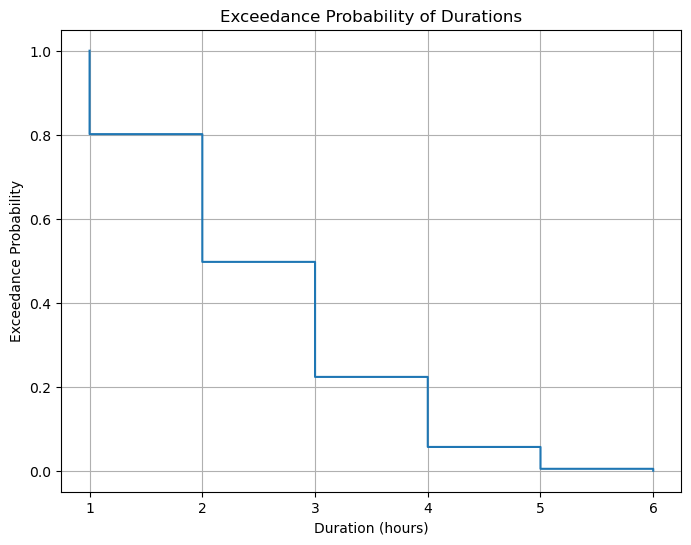

In [17]:
# Durations
sorted_durations = np.sort(selected_data['duration'])
exceedance_prob_duration = 1.0 - np.arange(1, len(sorted_durations) + 1) / len(sorted_durations)

plt.figure(figsize=(8,6))
plt.step(sorted_durations, exceedance_prob_duration, where='post')
plt.title('Exceedance Probability of Durations')
plt.xlabel('Duration (hours)')
plt.ylabel('Exceedance Probability')
plt.grid(True)



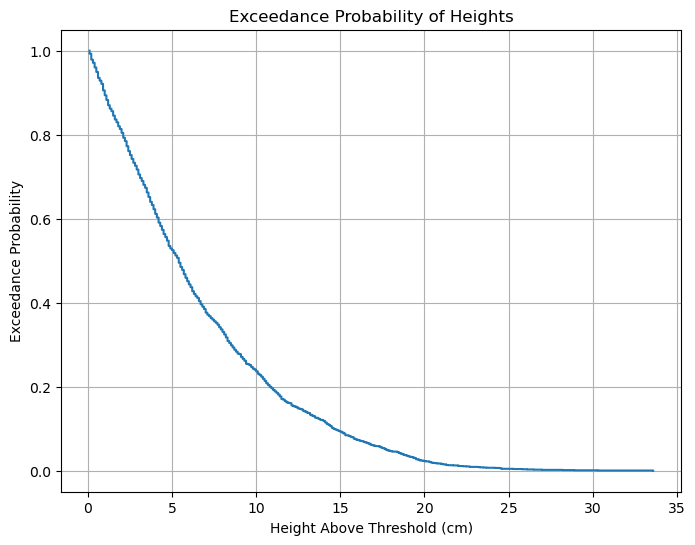

In [18]:
sorted_heights = np.sort(selected_data['height'])
exceedance_prob_height = 1.0 - np.arange(1, len(sorted_heights) + 1) / len(sorted_heights)

plt.figure(figsize=(8,6))
plt.step(sorted_heights, exceedance_prob_height, where='post')
plt.title('Exceedance Probability of Heights')
plt.xlabel('Height Above Threshold (cm)')
plt.ylabel('Exceedance Probability')
plt.grid(True)
plt.show()

In [19]:
selected_data = selected_data.to_dataframe()

In [20]:
# Define a function to categorize durations

# Define the ordered categories
duration_order = ['Short (1-2 hours)', 'Medium (3-5 hours)', 'Sustained (>5 hours)']

def categorize_duration(duration):
    if duration <= 2:
        return duration_order[0]
    elif 3 <= duration <= 5:
        return duration_order[1]
    else:
        return duration_order[2]



# Apply the function to create a new column
selected_data['duration_category'] = selected_data['duration'].apply(categorize_duration)


In [21]:
# Calculate the frequency of each category
category_counts = selected_data['duration_category'].value_counts()
total_events = len(data)

# Calculate the probability for each category
category_probs = category_counts / total_events

print("Frequency of Duration Categories:")
print(category_counts)

print("\nProbability of Duration Categories:")
print(category_probs)

Frequency of Duration Categories:
duration_category
Short (1-2 hours)       996
Medium (3-5 hours)      975
Sustained (>5 hours)      9
Name: count, dtype: int64

Probability of Duration Categories:
duration_category
Short (1-2 hours)       1.004032
Medium (3-5 hours)      0.982863
Sustained (>5 hours)    0.009073
Name: count, dtype: float64


In [22]:
# Ensure the categories are ordered
category_counts = category_counts.reindex(duration_order)

# Compute cumulative counts from shortest to longest
cumulative_counts = category_counts[::-1].cumsum()[::-1]

# Compute survival probabilities
survival_probs = cumulative_counts / total_events

print("\nCumulative Counts by Duration Category:")
print(cumulative_counts)

print("\nSurvival Probabilities by Duration Category:")
print(survival_probs)


Cumulative Counts by Duration Category:
duration_category
Short (1-2 hours)       1980
Medium (3-5 hours)       984
Sustained (>5 hours)       9
Name: count, dtype: int64

Survival Probabilities by Duration Category:
duration_category
Short (1-2 hours)       1.995968
Medium (3-5 hours)      0.991935
Sustained (>5 hours)    0.009073
Name: count, dtype: float64


In [23]:
# Calculate total observation period in years
total_years = (time.max()-time.min())/np.timedelta64(1, 's')/3600/24/365.25

# Calculate lambda
lambda_ = total_events / total_years

print(f"\nAverage number of events per year (lambda): {lambda_:.2f}")


Average number of events per year (lambda): 31.01


In [24]:
return_periods = 1 / (lambda_.item() * survival_probs)

# Display return periods
print("\nReturn Periods by Duration Category (in years):")
print(return_periods)


Return Periods by Duration Category (in years):
duration_category
Short (1-2 hours)       0.016155
Medium (3-5 hours)      0.032507
Sustained (>5 hours)    3.554047
Name: count, dtype: float64


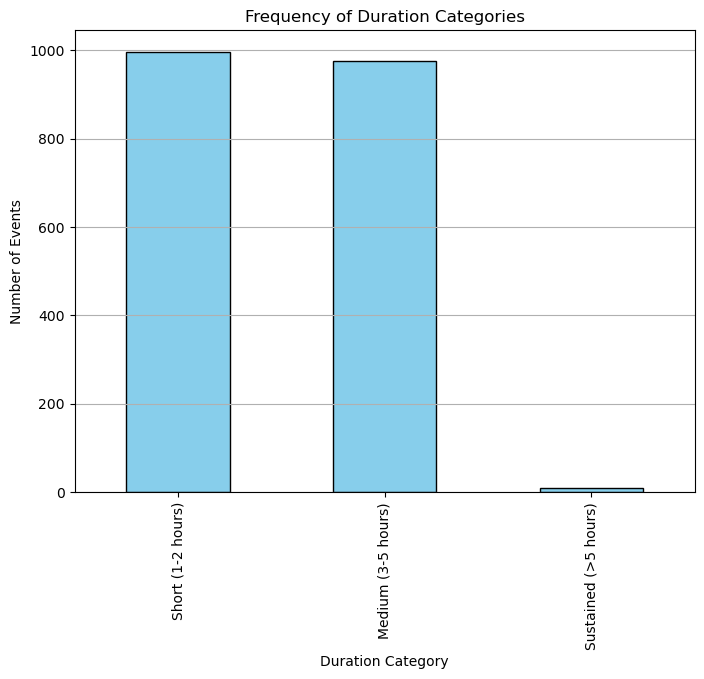

In [25]:
# Plot the frequency of each duration category
plt.figure(figsize=(8,6))
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frequency of Duration Categories')
plt.xlabel('Duration Category')
plt.ylabel('Number of Events')
plt.grid(axis='y')
plt.show()

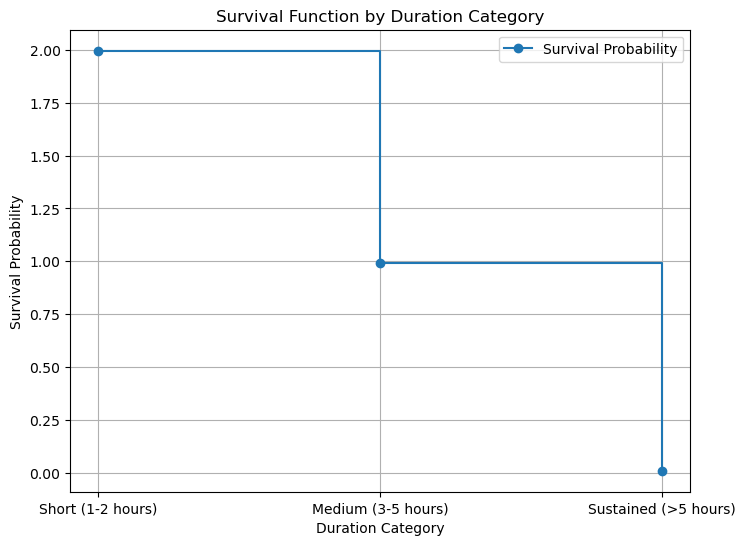

In [26]:
# Plot the survival function
plt.figure(figsize=(8,6))
plt.step(duration_order, survival_probs, where='post', marker='o', label='Survival Probability')
plt.title('Survival Function by Duration Category')
plt.xlabel('Duration Category')
plt.ylabel('Survival Probability')
# plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.show()

In [27]:
# Group data by duration category
grouped_data = selected_data.groupby('duration_category')

In [28]:
# Create a dictionary to store GEV parameters for each category
gev_params = {}
from scipy.stats import genextreme

for category, group in grouped_data:
    # Extract height data
    heights = group['height'].values
    
    # Fit GEV distribution
    c, loc, scale = genextreme.fit(heights)
    
    # Store parameters
    gev_params[category] = (c, loc, scale)

    print(f"GEV parameters for {category} category: c={c:.4f}, loc={loc:.4f}, scale={scale:.4f}")

GEV parameters for Medium (3-5 hours) category: c=-0.0381, loc=8.3896, scale=3.5952
GEV parameters for Short (1-2 hours) category: c=0.0466, loc=1.9776, scale=1.5236
GEV parameters for Sustained (>5 hours) category: c=0.5157, loc=19.8668, scale=8.3284


In [29]:
# Define return periods of interest
return_periods = np.arange(2,100,2)  # in years

# Calculate the non-exceedance probabilities
probabilities = 1 - (1 / (np.array(return_periods) * lambda_.item()))

# Create a DataFrame to store return levels
return_levels_df = pd.DataFrame(index=return_periods, columns=duration_order)

for category in duration_order:
    if category not in gev_params:
        continue
    c, loc, scale = gev_params[category]
    # Calculate return levels for each return period
    return_levels = genextreme.ppf(probabilities, c, loc=loc, scale=scale)
    return_levels_df[category] = return_levels


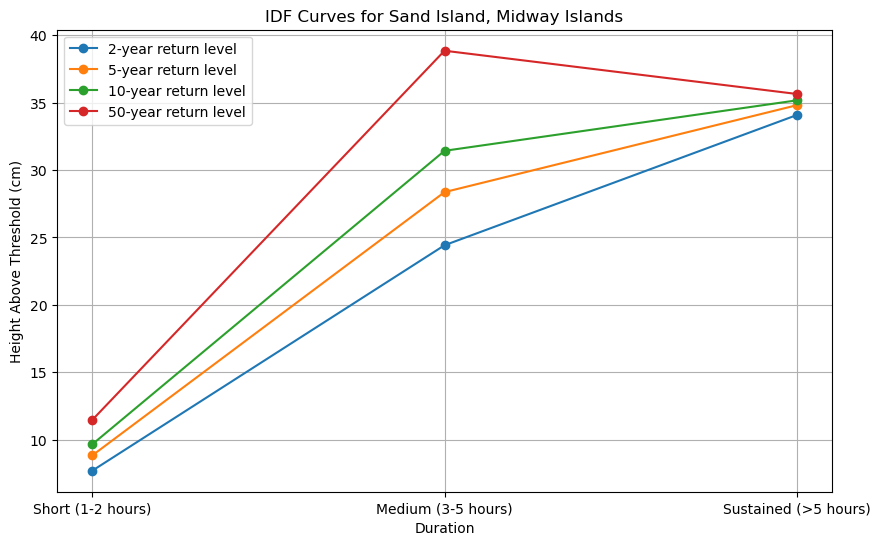

In [30]:
# Assume duration_order, gev_params, and lambda_ are predefined

return_periods_interest = [2, 5, 10, 50]  # in years



# Create an empty dict to store the return levels for the chosen return period
return_levels_by_period = {period: [] for period in return_periods_interest}

for return_period in return_periods_interest:
    # Calculate the non-exceedance probability for the chosen return period
    probability = 1 - (1 / (return_period * lambda_.item()))
    
    # Iterate over each duration category to calculate the return level for the chosen period
    for category in duration_order:
        if category not in gev_params:
            # If no data for this category, append NaN
            return_levels_by_period[return_period].append(np.nan)
            continue
        c, loc, scale = gev_params[category]
        
        # Calculate the return level for the specific return period
        return_level = genextreme.ppf(probability, c, loc=loc, scale=scale)
        return_levels_by_period[return_period].append(return_level)

# Plot the return level curve for the chosen return period (e.g., 2-year)
plt.figure(figsize=(10, 6))
for return_period in return_periods_interest:
    # Plot the return level curve for each return period
    plt.plot(duration_order, return_levels_by_period[return_period], marker='o', label=f'{return_period}-year return level')

plt.title(f'IDF Curves for' + ' ' + station_names[i])
plt.xlabel('Duration')
plt.ylabel('Height Above Threshold (cm)')
plt.grid(True)
plt.legend()

plt.show()

We can't do a curve here because the distribution of durations is very limited (at most stations). 

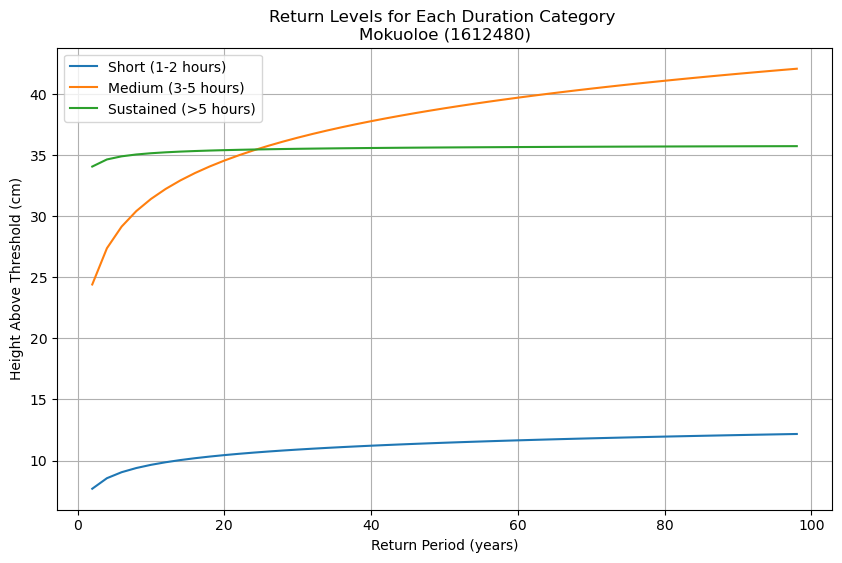

In [31]:
# Now plot the return levels for each duration category
plt.figure(figsize=(10, 6))

for category in duration_order:
    if category not in gev_params:
        continue
    c, loc, scale = gev_params[category]
    
    # Calculate the return levels for each return period
    return_levels = genextreme.ppf(1 - (1 / (np.array(return_periods) * lambda_.item())), c, loc=loc, scale=scale)
    
    # Plot the return levels for each duration category
    plt.plot(return_periods, return_levels,  label=category)

plt.title('Return Levels for Each Duration Category \n' + station_name + ' (' + station_id + ')'   )
plt.xlabel('Return Period (years)')
plt.ylabel('Height Above Threshold (cm)')

plt.grid(True)
plt.legend()